# Réseau d'accès radio TP
Lucas Hocquette - Quentin Goulas

### Exercice 1 : Capacité d'un système CDMA

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [31]:
# 1
def sample_users(K,R):
    v = np.random.uniform(low=0,high=R**2,size=K)
    theta = np.random.uniform(low=0,high=2*np.pi,size=K)
    r = np.sqrt(v)
    x,y = r*np.cos(theta), r*np.sin(theta)
    return x,y

In [32]:
# 2
r = 1
W = 3.84*10**6
theta = 0.4
sigma2 = 10**(-104/10)*1e-3
P = 10**(40/10)*1e-3

def measure_achievement_ratio(K,R,gamma,n_avg=1):
    x,y = sample_users(K,r)
    d = np.sqrt(x**2+y**2)
    L = -128.1 - 37.6*np.log10(d)
    l = 10**(L/10)
    history = np.zeros(n_avg)
    for i in range(n_avg):
        h = np.random.exponential(0.5,K)
        g = l*h
        p = P/K
        SINR = W/R*p*g/(theta*(K-1)*p*g+sigma2)
        history[i] = np.mean(SINR>=gamma)

    return history

print(f'The percentage for which the decoding condition is satisified is : {measure_achievement_ratio(20,32*1e3,10**(7/10))[0]*100}%')

The percentage for which the decoding condition is satisified is : 95.0%


In [16]:
# 3 and 4

achievement_ratio = measure_achievement_ratio(20,32*1e3,10**(7/10),100)
print(f'delta = {np.mean(achievement_ratio)*100}%')

delta = 97.85000000000001%


[1.         1.         1.         1.         0.998      0.99333333
 0.99714286 0.9975     0.99444444 0.991      0.99272727 0.9925
 0.98384615 0.98571429 0.98333333 0.986875   0.98705882 0.97722222
 0.98421053 0.983      0.9752381  0.97409091 0.96217391 0.97958333
 0.9704     0.97269231 0.96296296 0.97714286 0.96827586 0.95033333
 0.95903226 0.9465625  0.94909091 0.95558824 0.94514286 0.93972222
 0.93162162 0.95105263 0.91282051 0.9225     0.90243902 0.90619048
 0.89209302 0.87931818 0.90666667 0.8773913  0.84085106 0.90958333
 0.85       0.8296     0.82078431 0.79153846 0.7645283  0.74037037
 0.66745455 0.62785714 0.5945614  0.47896552 0.42932203 0.277
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        

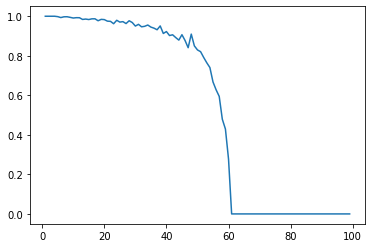

In [54]:
# 5

K_values = np.array(range(1,100))
deltas = np.zeros(len(K_values))

for i,K in enumerate(K_values) :
    ach_rat = measure_achievement_ratio(K,32*1e3,10**(7/10),100)
    deltas[i] = np.mean(ach_rat)

print(deltas)
print(f'The maximum number of users on the network is {K_values[np.sum(deltas>=0.9)]}')

plt.plot(K_values,deltas)
plt.show()

### Exercice 2 : Contrôle de puissance dans un système CDMA : Capacité et solution itérative

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

$$ 
F = \begin{pmatrix} 
        0, \frac{g_2}{R_1g_1}, \cdots, \frac{g_k}{R_1g_1} \\
        \frac{g_1}{R_2g_2}, 0, \ddots, \vdots \\
        \vdots, \ddots, \ddots, \vdots \\
        \frac{g_1}{R_kg_k}, \cdots, \cdots, 0
    \end{pmatrix}       
$$

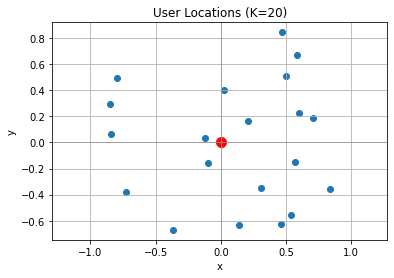

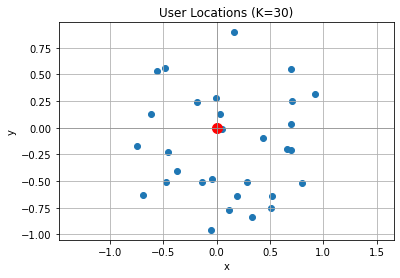

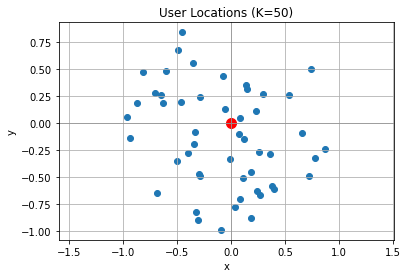

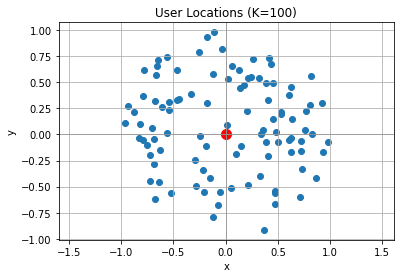

In [37]:
# 1.a

def sample_users(K,R):
    v = np.random.uniform(low=0,high=R**2,size=K)
    theta = np.random.uniform(low=0,high=2*np.pi,size=K)
    r = np.sqrt(v)
    x,y = r*np.cos(theta), r*np.sin(theta)
    return x,y

for K in [20,30,50,100]:
    # Example usage
    R = 1
    x, y = sample_users(K, R)

    plt.scatter(x, y)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f"User Locations (K={K})")
    plt.axhline(0, color='gray', linewidth=0.5)
    plt.axvline(0, color='gray', linewidth=0.5)
    plt.axis('equal')
    plt.gca().set_aspect('equal')
    plt.grid(True)
    plt.scatter(0, 0, color='red', s=100)
    plt.show()

In [39]:
# 1.b
# K = np.array([20, 30, 50, 100],dtype=np.int32)
K = np.array(range(10,100,2), dtype=np.int32)
R = 1
r1,r2 = 15*1e3,32*1e3
W = 3.84*10**6
theta = 0.4
gamma1, gamma2  = 10**(5/10), 10**(7/10)
Rho = np.array([])

def generate_F(k,R,r1,r2,gamma1,gamma2,W,theta):
    x,y = sample_users(k,R)
    r = np.concatenate((r1*np.ones(k//2),r2*np.ones(k//2)))
    gamma = np.concatenate((gamma1*np.ones(k//2),gamma2*np.ones(k//2)))
    lamda = 0.5
    # h = np.random.exponential(1/lamda,k)
    h = np.ones(k)
    d = np.sqrt(x**2+y**2)
    L = -128.1 - 37.6*np.log10(d)
    l = 10**(L/10)
    g = l*h
    G1,G2 = np.meshgrid(gamma*r*g,g)
    F = (theta/W)*G1 / G2
    F[np.eye(k,dtype=bool)] = 0
    return F, r, gamma, g

for k in K:
    F,_,_,_ = generate_F(k,R,r1,r2,gamma1,gamma2,W,theta)
    rho = np.max(np.abs(np.linalg.eigvals(F)))
    Rho = np.append(Rho,rho)

Kmax = np.max(K[Rho<1])
print(Kmax)

92


In [46]:

#1.c
k = Kmax

x,y = sample_users(k,R)
r = np.concatenate((r1*np.ones(k//2),r2*np.ones(k//2)))
gamma = np.concatenate((gamma1*np.ones(k//2),gamma2*np.ones(k//2)))
lamda = 0.5
h = np.ones(k)
d = np.sqrt(x**2+y**2)
L = -128.1 - 37.6*np.log10(d)
l = 10**(L/10)
g = l*h
G1,G2 = np.meshgrid(gamma*r*g,g)
F = (theta/W)*G1 / G2
F[np.eye(k,dtype=bool)] = 0

sigma2 = 10**(-104/10)/1000
b = sigma2*(1/(3.84*10**6))*r*gamma/g
P =  np.linalg.inv(np.eye(k) - F)@b

print(10*np.log10(P*1000)) # display the power allocation in dBm

def SINR(W,R,P,G,theta,sigma2):
    alpha = W/R
    pg = P*G
    p,_ = np.meshgrid(P,P)
    p[np.eye(len(p),dtype=bool)] = 0
    sm = np.sum(p,axis=1)*g
    return alpha*pg/(theta*sm+sigma2)

[24.69558877 18.04235122  4.56237522 17.88133785 25.40406291 26.13213816
 16.75190661 23.5842046  19.35241711 14.98025376  5.73950267 20.34496853
 25.09474067  0.50594936 24.12149908 20.31487367 25.54368761 18.56457173
 22.35040497 25.37111837 25.6218739  25.72162275 25.28411696  7.61662409
 17.6853328  25.841986   24.42255789 23.53272549 25.55726173 24.05442799
 23.78666048 23.69352012 12.84636135 25.11861216 25.6548215  24.46505516
 16.23109834 22.66679085 15.81690725 24.48487025 14.06432604 -0.6190207
 23.22715742 25.755025   18.91510694 25.13685257 26.18359233 26.90160492
 19.00765667 -3.9928352  24.5843409  26.3144529  23.551277   23.80472197
 15.94311045 18.92891778 26.02665736  4.65390965 15.02027005 18.00619658
 18.77885285 23.69794136 19.22627243  9.64484612  9.71566471 24.71092614
 14.41595874 21.07197484 23.06740268 23.69918285  8.34028846 25.91302979
 13.63574246 15.43665217 17.03166484 -0.34664426 20.60159765 22.08484331
 14.12652451 19.82295011 23.40986684 20.42558089 25.

k=10, num_iteration=4
k=12, num_iteration=4
k=14, num_iteration=5
k=16, num_iteration=3
k=18, num_iteration=4
k=20, num_iteration=4
k=22, num_iteration=3
k=24, num_iteration=4
k=26, num_iteration=5
k=28, num_iteration=5
k=30, num_iteration=5
k=32, num_iteration=5
k=34, num_iteration=5
k=36, num_iteration=4
k=38, num_iteration=5
k=40, num_iteration=5
k=42, num_iteration=9
k=44, num_iteration=9
k=46, num_iteration=4
k=48, num_iteration=7
k=50, num_iteration=17
k=52, num_iteration=8
k=54, num_iteration=7
k=56, num_iteration=9
k=58, num_iteration=8
k=60, num_iteration=14
k=62, num_iteration=17
k=64, num_iteration=14
k=66, num_iteration=16
k=68, num_iteration=8
k=70, num_iteration=18
k=72, num_iteration=33
k=74, num_iteration=22
k=76, num_iteration=21
k=78, num_iteration=20
k=80, num_iteration=16
k=82, num_iteration=27
k=84, num_iteration=19
k=86, num_iteration=58
k=88, num_iteration=31
k=90, num_iteration=49


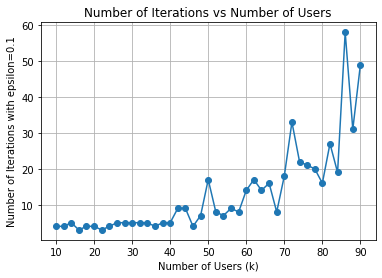

In [47]:
#1.d
K_list = np.array(range(10,Kmax,2), dtype=np.uint32)
epsilon = 0.1
iteration_list = np.zeros(len(K_list))

for idx in range(len(K_list)):
    k = K_list[idx]
    p = np.ones(k)
    new_p = np.ones(k)*0.1
    num_iteration = 0
    _, r, gamma, g = generate_F(k,R,r1,r2,gamma1,gamma2,W,theta)
    while not np.all(np.abs(p - new_p) < epsilon):
        p = new_p
        pg = p*g
        pg1,_ = np.meshgrid(pg,pg)
        pg1[np.eye(len(pg),dtype=bool)] = 0
        sm = np.sum(pg1,axis=1)
        new_p = (r*gamma*(theta*sm + sigma2))/(W*g)
        num_iteration += 1
    iteration_list[idx] = num_iteration
    print(f"k={k}, num_iteration={num_iteration}")

plt.plot(K_list, iteration_list, marker='o')
plt.xlabel('Number of Users (k)')
plt.ylabel(f'Number of Iterations with epsilon={epsilon}')
plt.title('Number of Iterations vs Number of Users')
plt.grid(True)
plt.show()
    

In [48]:
# 1.e

def iterativeE(gamma,beta,tol,seed):
    p=seed.copy()
    p_old = np.inf*np.ones_like(p)
    iter = 0
    while np.sum(abs(p-p_old))>=tol:
        p_old = p.copy()
        sinr = SINR(W,r,p,g,theta,sigma2)
        p = (1-beta)*p + beta*gamma/sinr*p
        iter +=1
    return p, iter

Beta = [0.1,0.3,0.5,0.8,1]
Niter = np.zeros_like(Beta)
_, r, gamma, g = generate_F(Kmax,R,r1,r2,gamma1,gamma2,W,theta)

seed = np.ones(Kmax)
for b in range(len(Beta)):
    p,iter = iterativeE(gamma,Beta[b],1e-3,seed)
    Niter[b] = iter

print(Niter)

[2734. 1111.  722.  483.  398.]


In [49]:
# 1.f

def iterativeF(gamma,alpha,tol,seed,maxIter):
    p = seed.copy()
    p_old = np.inf*np.ones_like(p)
    iter = 0
    while (np.sum(abs(p-p_old))>=tol) & (iter<maxIter):
        p_old = p.copy()
        sinr = SINR(W,r,p,g,theta,sigma2)
        p[sinr<gamma] = alpha*p_old[sinr<gamma]
        p[sinr>gamma] = p_old[sinr>gamma]/alpha
        iter +=1
    return p, iter

Alpha = 10**(np.linspace(0.25,1.5,7)/10)
Niter = np.zeros_like(Alpha)
_, r, gamma, g = generate_F(Kmax,R,r1,r2,gamma1,gamma2,W,theta)

seed = np.ones(Kmax)
for a in range(len(Alpha)):
    p,iter = iterativeF(gamma,Alpha[a],1e-3,seed,5e3)
    Niter[a] = iter

print(Niter)

[5000. 5000. 5000. 5000. 5000. 5000. 5000.]


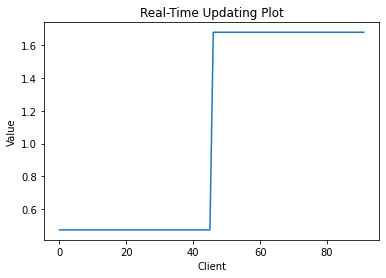

0.013233833405258688


In [ ]:
# 1.g

# plt.ion()  # Turn on interactive mode

fig, ax = plt.subplots()
ax.set_title('Real-Time Updating Plot')
ax.set_xlabel('Client')
ax.set_ylabel('Value')

# Initialize an empty list for the data
p_plot = []

# Plot the initial empty data
line, = ax.plot(p_plot)

# Display the plot
display(fig)

def update_plot(p):
    clear_output(wait=True)
    line.set_ydata(p)
    line.set_xdata(range(len(p)))
    ax.relim()
    ax.autoscale_view()
    display(fig)

def iterativeG(gamma,alpha,tol,maxIter):
    p = np.ones(Kmax)
    p_old = np.inf*np.ones_like(p)
    iter = 0
    while (np.sum(abs(p-p_old))/Kmax>=tol) & (iter<maxIter):
        p_old = np.copy(p)
        sinr = SINR(W,r,p,g,theta,sigma2)
        p[sinr > alpha*gamma*p_old] = p_old[sinr > alpha*gamma*p_old]/alpha
        p[sinr < gamma*alpha**(-1)] = p_old[sinr < gamma*alpha**(-1)]*alpha
        iter += 1
        if iter % 1 == 0:
            update_plot(p)
            print(np.sum(abs(p-p_old))/Kmax)
    return p, iter

Alpha = 10**(np.linspace(0.25,1.5,7)/10)
#Alpha = [10**(0.25/10), 10**(0.25/10), 10**(0.25/10)]
Niter = np.zeros_like(Alpha)
_, r, gamma, g = generate_F(Kmax,R,r1,r2,gamma1,gamma2,W,theta)
epsilon = 5e-3

for a in range(len(Alpha)):
    p_alpha,iter = iterativeG(gamma,Alpha[a],epsilon,5e3)
    Niter[a] = iter

print(Niter)

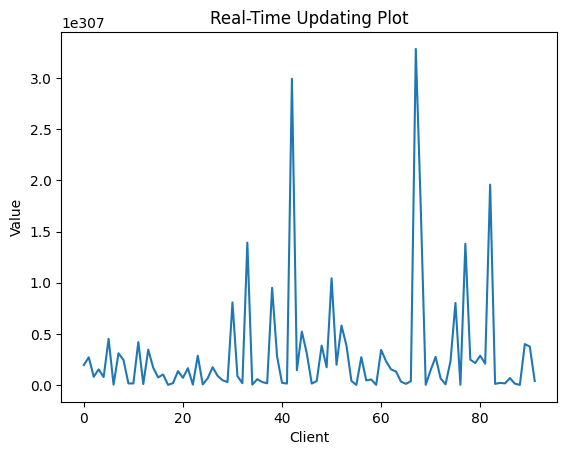

[1470.  704.  544.  437.  398.]


C:\Users\goula\AppData\Local\Temp\ipykernel_26896\4155344215.py:30: RuntimeWarning: invalid value encountered in multiply
  p = (1-beta)*p + beta*gamma/sinr*p


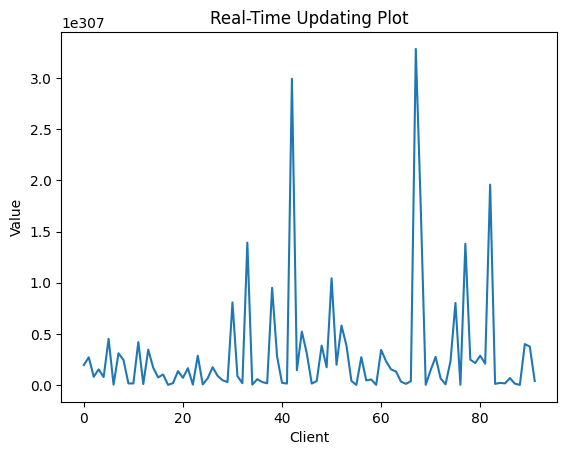

In [56]:
# 2.a


def generate_F2(k,R,r1,r2,gamma1,gamma2,W,theta):
    x,y = sample_users(k,R)
    r = np.concatenate((r1*np.ones(k//2),r2*np.ones(k//2)))
    gamma = np.concatenate((gamma1*np.ones(k//2),gamma2*np.ones(k//2)))
    d = np.sqrt(x**2+y**2)
    L = -128.1 - 37.6*np.log10(d)
    l = 10**(L/10)
    return r, gamma

def iterativeE(gamma,beta,tol,seed,k):
    p=seed
    p_old = np.inf*np.ones_like(p)
    iter = 0
    lamda = 0.5
    while np.sum(abs(p-p_old))>=tol:

        # new h at each iteration
        h = np.random.exponential(1/lamda,k)
        # h = np.ones(k)
        g = l*h
        G1,G2 = np.meshgrid(gamma*r*g,g)
        F = (theta/W)*G1 / G2
        F[np.eye(k,dtype=bool)] = 0

        p_old = p
        sinr = SINR(W,r,p,g,theta,sigma2)
        p = (1-beta)*p + beta*gamma/sinr*p
        iter +=1
        if iter % 5 == 0:
            update_plot(p)
        
    return p, iter

fig, ax = plt.subplots()
ax.set_title('Real-Time Updating Plot')
ax.set_xlabel('Client')
ax.set_ylabel('Value')
p_plot = []
line, = ax.plot(p_plot)
display(fig)


Beta = [0.1,0.3,0.5,0.8,1]
Niter = np.zeros_like(Beta)
r, gamma = generate_F2(Kmax,R,r1,r2,gamma1,gamma2,W,theta)

seed = np.ones(Kmax)
for b in range(len(Beta)):
    p,iter = iterativeE(gamma,Beta[b],1e-3,seed,Kmax)
    Niter[b] = iter

print(Niter)

### Exercice 3 : Comparison between CDMA and TDMA systems

In [52]:
# 1

r = 1
W = 3.84*10**6
theta = 0.4
sigma2 = 10**(-104/10)*1e-3
P = 10**(40/10)*1e-3

def measure_achievement_ratio(K,R,gamma,n_avg=1):
    x,y = sample_users(K,r)
    d = np.sqrt(x**2+y**2)
    L = -128.1 - 37.6*np.log10(d)
    l = 10**(L/10)
    history = np.zeros((n_avg,1))
    for i in range(n_avg):
        h = np.random.exponential(0.5,K)
        g = l*h
        p = P/K
        SINR = W/R*p*g/(theta*(K-1)*p*g+sigma2)
        history[i] = np.mean(SINR>=gamma)

    return history

K_values = np.array(range(1,100))
deltas = np.zeros(len(K_values))

for i,K in enumerate(K_values) :
    ach_rat = measure_achievement_ratio(K,240*1e3,10**(10/10),100)
    deltas[i] = np.mean(ach_rat)

print(deltas)
print(f'The maximum number of users on the network is {K_values[np.sum(deltas>=0.9)]}')

[1.         0.93       0.91666667 0.88       0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]
The maximum number of